In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch 
from argparse import Namespace
from tqdm import tqdm
import pickle 
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()


# Add the path to the directory containing the sybil module
sys.path.append('/workspace/home/tengyuezhang/sybil_cect/code/Sybil')
from sybil.utils.metrics import concordance_index, get_survival_metrics
from sybil import Sybil, Serie
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [14]:
dataset_name = 'LungX'
# load data
df = pd.read_csv('/workspace/home/kkulkarni/Sybil/Results/Lungx/Corrected_lungx_with_risk_scores.csv')
# rename 'LungCancer' column to 'event'
df = df.rename(columns={'Diagnosis': 'event'})
# proportion of positive samples 
aapm_percent_positive = (df['event'].sum() / len(df)) 
print(df['event'].sum(), aapm_percent_positive)

28 0.5185185185185185


In [15]:
# load checkpoint (to get censor distribution on training set that is used to calculate c-index)
model = Sybil("sybil_ensemble")

/home/tengyuezhang/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tengyuezhang/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# get y label for each year 
max_followup = 1

def calculate_y_seq(event, time_to_event, max_followup=6):
    # Initialize y_0, y_1, ..., y_5 as 0
    y_seq = np.zeros(max_followup)

    if event == 1:
        # Convert time_to_event to integer index (year)
        event_year = 0 
        event_year = min(event_year, max_followup)
        y_seq[event_year:] = 1
    
    return y_seq

for i in range(max_followup):
    df[f'y_{i}'] = np.nan
for index, row in df.iterrows():
    event = row['event']    
    # Calculate y_seq
    y_seq = calculate_y_seq(event, None, max_followup=max_followup)
    
    # Assign y_0, ..., y_5 to the corresponding columns in the DataFrame
    for i in range(max_followup):
        df.at[index, f'y_{i}'] = y_seq[i]
# print(df.head())

In [17]:
# Calculate time-dependent AUC and C-index on the entire dataset 

In [6]:
# get scores and labels 
selected_columns = ['pred_risk_year_0']
pred_risk_scores = df[selected_columns].values.tolist()

# Convert event times and event observed to lists
# event_times = df['years_to_event'].tolist()
event_times = [0] * len(df)
event_observed = df['event'].tolist()

input_dict = {
    "probs": torch.tensor(pred_risk_scores), 
    "censors": torch.tensor(event_times), 
    "golds": torch.tensor(event_observed)
}

args = Namespace(
    max_followup=max_followup, censoring_distribution=model._censoring_dist
)

aapm_out = get_survival_metrics(input_dict, args)

# print(f"nlst_out: \n{nlst_out}")

In [7]:
aapm_out

{'1_year_auc': 0.592032967032967,
 '1_year_apscore': 0.6431771153783791,
 '1_year_prauc': 0.6186339776582876,
 '1_year_roc_curve': {'fpr': array([0.        , 0.03846154, 0.03846154, 0.03846154, 0.07692308,
         0.11538462, 0.11538462, 0.15384615, 0.26923077, 0.30769231,
         0.30769231, 0.34615385, 0.34615385, 0.38461538, 0.46153846,
         0.53846154, 0.61538462, 0.65384615, 0.69230769, 0.73076923,
         0.80769231, 0.84615385, 0.88461538, 0.92307692, 0.96153846,
         1.        ]),
  'tpr': array([0.        , 0.        , 0.07142857, 0.21428571, 0.21428571,
         0.25      , 0.39285714, 0.42857143, 0.42857143, 0.5       ,
         0.57142857, 0.57142857, 0.60714286, 0.60714286, 0.60714286,
         0.60714286, 0.64285714, 0.64285714, 0.67857143, 0.75      ,
         0.75      , 0.75      , 0.89285714, 0.89285714, 1.        ,
         1.        ]),
  'thresholds': array([1.66147566e+00, 6.61475718e-01, 4.41666663e-01, 3.51666659e-01,
         2.93565363e-01, 2.903921

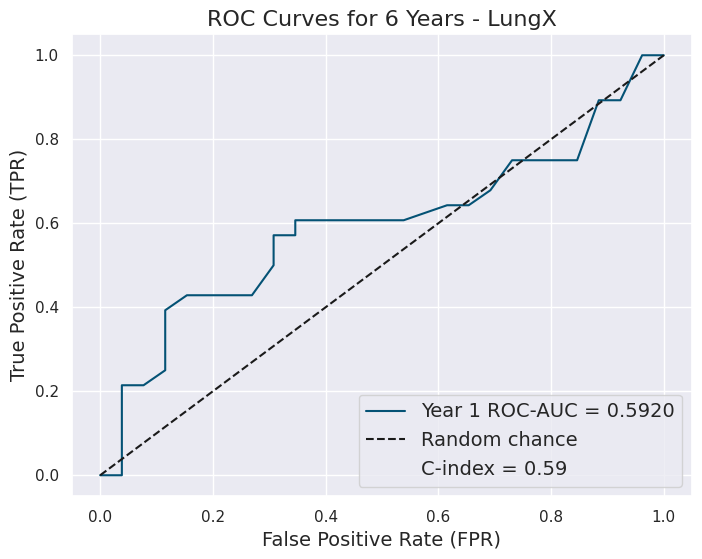

In [9]:
# Plotting
colors = ['#045275', '#089099', '#7CCBA2', '#FABF7B', '#E05C5C', '#AB1866']

plt.figure(figsize=(8, 6))

for year in range(1, 2):
    # Extract FPR, TPR, and AUROC for the current year
    roc_curve_data = aapm_out[f'{year}_year_roc_curve']
    fpr = roc_curve_data['fpr']
    tpr = roc_curve_data['tpr']
    auroc = aapm_out[f'{year}_year_auc']

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Year {year} ROC-AUC = {auroc:.4f}', color=colors[year-1])

# Plotting random chance
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')

# Include C-index in the legend
plt.plot([], [], ' ', label=f"C-index = {aapm_out['c_index']:.2f}")

# Set plot labels and title
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'ROC Curves for 6 Years - {dataset_name}', fontsize=16)
plt.legend(loc='lower right', fontsize=14)
plt.show()

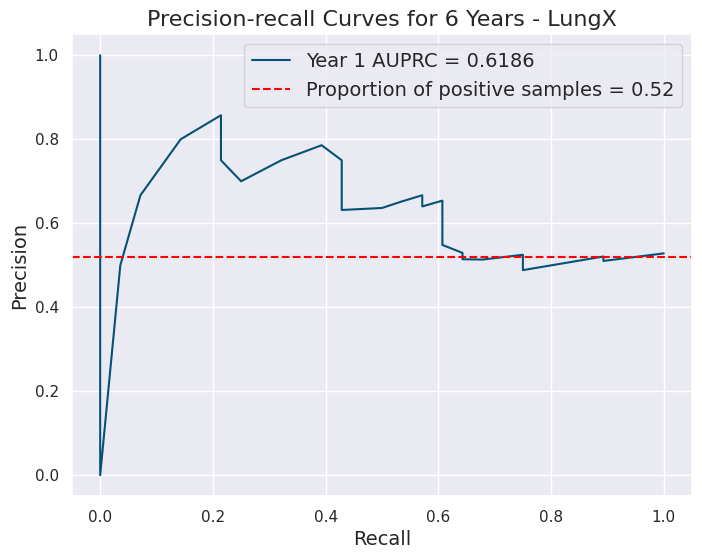

In [10]:
plt.figure(figsize=(8, 6))

for year in range(1, 2):
    pr_curve_data = aapm_out[f'{year}_year_pr_curve']
    precision = pr_curve_data['precision'] 
    recall = pr_curve_data['recall']
    pr_auc = aapm_out[f'{year}_year_prauc']

    # Plot precision-recall curve
    plt.plot(recall, precision, label=f'Year {year} AUPRC = {pr_auc:.4f}', color=colors[year-1])

# Plot horizontal line at 0.1515 to indicate the proportion of positive samples
plt.axhline(y=aapm_percent_positive, color='red', linestyle='--', 
            label=f'Proportion of positive samples = {aapm_percent_positive:.2f}')
# Set plot labels and title
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title(f'Precision-recall Curves for 6 Years - {dataset_name}', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [12]:
# Bootstrapping (AUROC, C-index, etc)
# If this hasn't been calculated before, or you want to re-calculate the values, perform bootstrapping and save the results. 

In [11]:
# Parameters
n_bootstraps = 5000 
random_seed = 42 
np.random.seed(random_seed)

# Define where to save bootstrapping results Sybil/Results/SPIE_AAPM/bootstrap_results_aapm.pkl
bootstrap_result_path = '/workspace/home/kkulkarni/Sybil/Results/Lungx/bootstrap_results_aapm.pkl'

In [14]:
auroc_scores_all_years = {f'year_{i}': [] for i in range(max_followup)} 
auprc_scores_all_years = {f'year_{i}': [] for i in range(max_followup)} 

# define args for c-index calculation 
args = Namespace(
    max_followup=max_followup, censoring_distribution=model._censoring_dist
)

# to store bootstrapped metrics 
bootstrapped_auroc = {f'year_{i+1}': [] for i in range(max_followup)}
bootstrapped_auprc = {f'year_{i+1}': [] for i in range(max_followup)}
bootstrapped_c_indices = [] 

# for i in range(n_bootstraps): 
for i in tqdm(range(n_bootstraps), desc="Bootstrapping", ncols=100):
    # resample data with replacement 
    bootstrap_indices = resample(range(len(df)), replace=True, n_samples=len(df))
    df_bootstrap = df.iloc[bootstrap_indices]
    pred_risk_scores_bootstrap = df_bootstrap[selected_columns].values.tolist()
    # event_times_bootstrap = df_bootstrap['years_to_event'].tolist() 
    event_times_bootstrap = [0] * len(df_bootstrap)
    event_observed_bootstrap = df_bootstrap['event'].tolist() 
    
    input_dict_bootstrap = {
        "probs": torch.tensor(pred_risk_scores_bootstrap), 
        "censors": torch.tensor(event_times_bootstrap), 
        "golds": torch.tensor(event_observed_bootstrap)
    }
    
    bootstrap_metrics = get_survival_metrics(input_dict_bootstrap, args)
    
    # print(bootstrap_metrics) 
    
    for year in range(1, max_followup+1): 
        bootstrapped_auroc[f'year_{year}'].append(bootstrap_metrics[f'{year}_year_auc'])
        bootstrapped_auprc[f'year_{year}'].append(bootstrap_metrics[f'{year}_year_prauc'])
    bootstrapped_c_indices.append(bootstrap_metrics['c_index'])
    

Bootstrapping: 100%|███████████████████████████████████████████| 5000/5000 [00:26<00:00, 186.77it/s]


In [15]:
import pickle 
bootstrap_results = {
    'bootstrapped_auroc': bootstrapped_auroc,  # AUROC
    'bootstrapped_c_indices': bootstrapped_c_indices,  # C-index
    'bootstrapped_auprc': bootstrapped_auprc, 
}
with open(bootstrap_result_path, 'wb') as f:
    pickle.dump(bootstrap_results, f)

In [12]:
# Load the dictionary from the pickle file
with open(bootstrap_result_path, 'rb') as f:
    loaded_results = pickle.load(f)

# Accessing the loaded data
bootstrapped_auroc = loaded_results['bootstrapped_auroc']
bootstrapped_c_indices = loaded_results['bootstrapped_c_indices']
bootstrapped_auprc = loaded_results['bootstrapped_auprc']

In [13]:
# 1) calculate mean AUROC and CIs for each year
auroc_results = {}
for year in range(1, max_followup+1):
    auroc_scores = bootstrapped_auroc[f'year_{year}']
    mean_auroc = np.mean(auroc_scores)
    lower_bound = np.percentile(auroc_scores, 2.5)
    upper_bound = np.percentile(auroc_scores, 97.5)
    auroc_results[f'year_{year}'] = {
        'mean_auroc': mean_auroc,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

print('======== AUROC ========')
for year in range(1, max_followup+1): 
    year_auroc = auroc_results[f'year_{year}']['mean_auroc']
    year_lower = auroc_results[f'year_{year}']['lower_bound']
    year_upper = auroc_results[f'year_{year}']['upper_bound']
    print(f'Year {year} mean AUROC={year_auroc:.4f} (CI: [{year_lower:.2f}-{year_upper:.2f}])')
    
# 2) calculate mean AUPRC and CIs for each year 
auprc_results = {}
for year in range(1, max_followup+1):
    auprc_scores = bootstrapped_auprc[f'year_{year}']
    mean_auprc = np.mean(auprc_scores)
    lower_bound = np.percentile(auprc_scores, 2.5)
    upper_bound = np.percentile(auprc_scores, 97.5)
    auprc_results[f'year_{year}'] = {
        'mean_auprc': mean_auprc,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

print('======== AUPRC ========')
for year in range(1, max_followup+1): 
    year_auprc = auprc_results[f'year_{year}']['mean_auprc']
    year_lower = auprc_results[f'year_{year}']['lower_bound']
    year_upper = auprc_results[f'year_{year}']['upper_bound']
    print(f'Year {year} mean AUROC={year_auprc:.4f} (CI: [{year_lower:.2f}-{year_upper:.2f}])')

# 3) calculate mean C-index and CI
mean_c_index = np.mean(bootstrapped_c_indices)
c_index_lower_bound = np.percentile(bootstrapped_c_indices, 2.5)
c_index_upper_bound = np.percentile(bootstrapped_c_indices, 97.5)

print('======== C-index ========')
print(f'Mean AUROC={mean_c_index:.4f} (CI: [{c_index_lower_bound:.2f}-{c_index_upper_bound:.2f}])')

======== AUROC ========
Year 1 mean AUROC=0.5913 (CI: [0.43-0.75])
======== AUPRC ========
Year 1 mean AUROC=0.6308 (CI: [0.43-0.83])
======== C-index ========
Mean AUROC=0.5913 (CI: [0.43-0.75])


In [14]:
# Plot ROC curves and time-dependent AUROC with CI

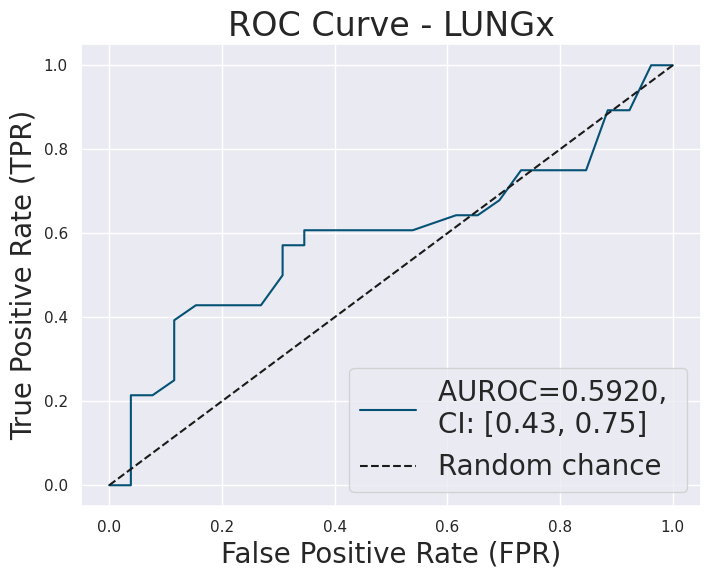

In [18]:
# Extract the C-index
# c_index = aapm_out['c_index']

# Plotting
plt.figure(figsize=(8, 6))

for year in range(1, max_followup+1):
    # Extract FPR, TPR, and AUROC for the current year
    roc_curve_data = aapm_out[f'{year}_year_roc_curve']
    fpr = roc_curve_data['fpr']
    tpr = roc_curve_data['tpr']
    year_auroc = aapm_out[f'{year}_year_auc']
    year_lower = auroc_results[f'year_{year}']['lower_bound']
    year_upper = auroc_results[f'year_{year}']['upper_bound']

    # Plot ROC curve
    plt.plot(fpr, tpr, 
            label=f'AUROC={year_auroc:.4f}, \nCI: [{year_lower:.2f}, {year_upper:.2f}]', 
             color=colors[year-1]
    )

# Plotting random chance
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')

# Include C-index in the legend
# plt.plot([], [], ' ', label=f'C-index = {c_index:.2f}')

# Set plot labels and title
plt.xlabel('False Positive Rate (FPR)', fontsize=20)
plt.ylabel('True Positive Rate (TPR)', fontsize=20)
plt.title(f'ROC Curve - LUNGx', fontsize=24)
plt.legend(loc='lower right', fontsize=20)
plt.show()

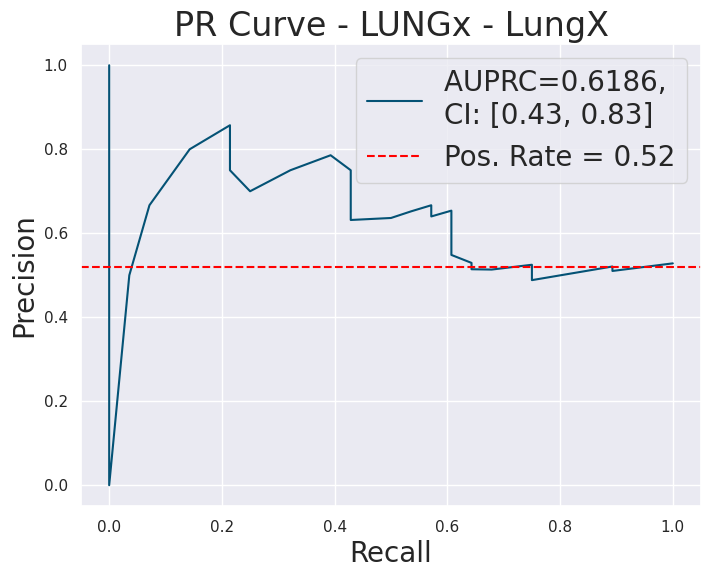

In [19]:
plt.figure(figsize=(8, 6))

for year in range(1, max_followup+1):
    # Extract FPR, TPR, and AUROC for the current year
    pr_curve_data = aapm_out[f'{year}_year_pr_curve']
    recall = pr_curve_data['recall']
    precision = pr_curve_data['precision']
    year_auprc = aapm_out[f'{year}_year_prauc']
    year_lower = auprc_results[f'year_{year}']['lower_bound']
    year_upper = auprc_results[f'year_{year}']['upper_bound']

    # Plot ROC curve
    plt.plot(recall, precision, 
            label=f'AUPRC={year_auprc:.4f}, \nCI: [{year_lower:.2f}, {year_upper:.2f}]', 
             color=colors[year-1]
    )

# Include C-index in the legend
# plt.plot([], [], ' ', label=f'C-index = {c_index:.2f}')

# Plot horizontal line at 0.1515 to indicate the proportion of positive samples
plt.axhline(y=aapm_percent_positive, color='red', linestyle='--', 
            label=f'Pos. Rate = {aapm_percent_positive:.2f}')


# Set plot labels and title
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title(f'PR Curve - LUNGx - {dataset_name}', fontsize=24)
plt.legend(loc='upper right', fontsize=20)
plt.show()

# Select Misclassified cases

In [18]:
RISK_CUTOFF=0.0121
IN_ATTN_MAPS_PATH = '/workspace/home/tengyuezhang/sybil_cect/visualizations/lungx_attention_maps_w_nodule'
OUT_SORTED_PATH = '/workspace/home/tengyuezhang/sybil_cect/visualizations/lungx_sorted_attention_maps'

In [19]:
# TP: event == 1 and pred_risk_year_1 >= RISK_CUTOFF
tp_df = df[(df['event'] == 1) & (df['pred_risk_year_1'] >= RISK_CUTOFF)]

# FP: event == 0 and pred_risk_year_1 >= RISK_CUTOFF
fp_df = df[(df['event'] == 0) & (df['pred_risk_year_1'] >= RISK_CUTOFF)]

# FN: event == 1 and pred_risk_year_1 < RISK_CUTOFF
fn_df = df[(df['event'] == 1) & (df['pred_risk_year_1'] < RISK_CUTOFF)]

# TN: event == 0 and pred_risk_year_1 < RISK_CUTOFF
tn_df = df[(df['event'] == 0) & (df['pred_risk_year_1'] < RISK_CUTOFF)]

In [20]:
print("True Positives (TP):", tp_df.shape[0])
print("False Positives (FP):", fp_df.shape[0])
print("False Negatives (FN):", fn_df.shape[0])
print("True Negatives (TN):", tn_df.shape[0])

True Positives (TP): 25
False Positives (FP): 23
False Negatives (FN): 3
True Negatives (TN): 3


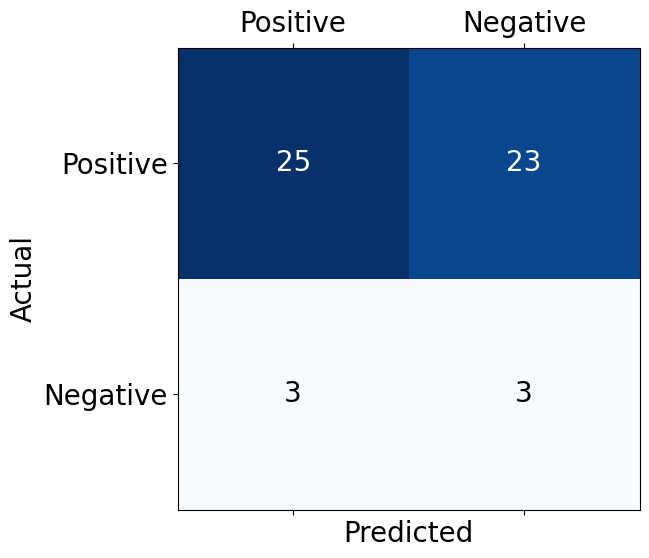

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

TP = tp_df.shape[0]
FP = fp_df.shape[0]
FN = fn_df.shape[0]
TN = tn_df.shape[0]

confusion_matrix = np.array([[TP, FP],
                             [FN, TN]])
categories = ['Positive', 'Negative']

fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(confusion_matrix, cmap='Blues')
# plt.colorbar(cax)

for (i, j), val in np.ndenumerate(confusion_matrix):
    color = cax.get_cmap()(cax.norm(confusion_matrix[i, j]))  # Get the RGBA color of the cell
    luminance = 0.2126 * color[0] + 0.7152 * color[1] + 0.0722 * color[2]  # Calculate luminance
    text_color = 'white' if luminance < 0.5 else 'black'  # Choose text color based on luminance
    ax.text(j, i, f'{val}', ha='center', va='center', color=text_color, fontsize=20)

ax.set_xticks([0, 1])
ax.set_xticklabels(categories, fontsize=20)
ax.set_yticks([0, 1])
ax.set_yticklabels(categories, fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
ax.set_ylabel('Actual', fontsize=20)

plt.show()


In [21]:
fn_df['Scan Number']

16    LUNGX-CT012
38    LUNGX-CT042
49    LUNGX-CT055
Name: Scan Number, dtype: object

In [22]:
fp_df

,AccessionNumber,SliceThickness,ConvolutionKernel,ImageOrientationPatient,Scan Number,index,Directory,Orientation,Year,timepoint,"Nodule Center x,y Position*",Nodule Center Image,event,pred_risk_year_0,pred_risk_year_1,pred_risk_year_2,pred_risk_year_3,pred_risk_year_4,pred_risk_year_5,y_0
0,1791342422597581,1.0,D,"[1, 0, 0, 0, 1, 0]",CT-TRAINING-BE001,0,/data/lung/SPIE_AAPM_Lung_CT_Challenge/CT-Trai...,axial,2007,0,405296.0,169.0,0,0.010901,0.020146,0.036231,0.045916,0.052504,0.078777,0.0
1,3027956620826907,1.0,D,"[1, 0, 0, 0, 1, 0]",CT-TRAINING-BE002,1,/data/lung/SPIE_AAPM_Lung_CT_Challenge/CT-Trai...,axial,2007,0,184268.0,117.0,0,0.010938,0.023848,0.042250,0.056078,0.068311,0.105301,0.0
2,1764192885731917,1.0,D,"[1, 0, 0, 0, 1, 0]",CT-TRAINING-BE006,2,/data/lung/SPIE_AAPM_Lung_CT_Challenge/CT-Trai...,axial,2007,0,449266.0,241.0,0,0.003951,0.015674,0.025373,0.034919,0.043507,0.063896,0.0
3,1110244576327898,1.0,D,"[1, 0, 0, 0, 1, 0]",CT-TRAINING-BE007,3,/data/lung/SPIE_AAPM_Lung_CT_Challenge/CT-Trai...,axial,2007,0,385206.0,194.0,0,0.012097,0.024064,0.052035,0.062793,0.079437,0.123949,0.0
4,2472930474421214,1.0,D,"[1, 0, 0, 0, 1, 0]",CT-TRAINING-BE010,4,/data/lung/SPIE_AAPM_Lung_CT_Challenge/CT-Trai...,axial,2007,0,120336.0,69.0,0,0.021629,0.038573,0.071919,0.079270,0.095846,0.135681,0.0
8,2771709101258922,1.0,D,"[1, 0, 0, 0, 1, 0]",LUNGX-CT001,10,/data/lung/SPIE_AAPM_Lung_CT_Challenge/LUNGx-C...,axial,2006,0,"135, 303",142.0,0,0.162194,0.266052,0.257810,0.294426,0.326781,0.382972,0.0
9,1356118425455229,1.0,D,"[1, 0, 0, 0, 1, 0]",LUNGX-CT002,11,/data/lung/SPIE_AAPM_Lung_CT_Challenge/LUNGx-C...,axial,2007,0,"330, 348",205.0,0,0.021629,0.038573,0.071919,0.079270,0.095846,0.135681,0.0
12,1612256726931044,1.0,D,"[1, 0, 0, 0, 1, 0]",LUNGX-CT007,16,/data/lung/SPIE_AAPM_Lung_CT_Challenge/LUNGx-C...,axial,2007,0,"170, 355",188.0,0,0.043411,0.069318,0.090725,0.133632,0.139195,0.194650,0.0
13,1529168099413703,1.0,D,"[1, 0, 0, 0, 1, 0]",LUNGX-CT008,17,/data/lung/SPIE_AAPM_Lung_CT_Challenge/LUNGx-C...,axial,2006,0,"172, 208",139.0,0,0.017994,0.037877,0.063983,0.069836,0.081818,0.125812,0.0
15,2726904962595395,1.0,D,"[1, 0, 0, 0, 1, 0]",LUNGX-CT011,20,/data/lung/SPIE_AAPM_Lung_CT_Challenge/LUNGx-C...,axial,2006,0,"179, 335",56.0,0,0.661476,0.784699,0.797350,0.819418,0.844000,0.865037,0.0


In [23]:
# Create the main folder
os.makedirs(OUT_SORTED_PATH, exist_ok=True)

# Create subfolders for FP, TP, TN, FN
subfolders = ['FP', 'TP', 'TN', 'FN']
for folder in subfolders:
    os.makedirs(os.path.join(OUT_SORTED_PATH, folder), exist_ok=True)

In [24]:
import shutil
def copy_folders_from_df(df,label, base_path, main_folder):
    for index, row in df.iterrows():
        scan_number = row['Scan Number']  # Adjust based on your DataFrame structure

        # Construct the source folder path
        source_folder = os.path.join(base_path, scan_number)  # Adjust path as needed

        # Determine the destination folder
        if label in ['FP', 'TP', 'TN', 'FN']:
            dest_folder = os.path.join(main_folder, label, scan_number)

            # Check if the destination folder already exists
            if not os.path.exists(dest_folder):
                # Check if the source folder exists
                if os.path.exists(source_folder):
                    # Copy the folder to the destination
                    shutil.copytree(source_folder, dest_folder)
                else:
                    print(f"Source folder {source_folder} does not exist.")
            else:
                print(f"Destination folder {dest_folder} already exists. Skipping copy.")

In [25]:
copy_folders_from_df(fn_df, 'FN', IN_ATTN_MAPS_PATH, OUT_SORTED_PATH )
# add FPs, etc. below 